## Exercise set 4: the generalized random forest

In this exercise set we will be working with the [generalized random forest](https://github.com/grf-labs/grf) by Athey et al. The package is written for the R programming language, and while there is a R-to-python interface in [rpy2](https://rpy2.bitbucket.io/) it can be tricky to get working. If you run into trouble, you can consider saving your data to a csv file and work directly in [R](https://www.r-project.org/) through [Rstudio](https://rstudio.com/products/rstudio/download/). 

In [172]:
import requests
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
import math

To highlight the usefulness of GRF we will be working with synthetic data in this exercise. In particular we will synthetically add a treatment effect to a dataset in which there otherwise is none. Furthermore we will make this effect heterogeneous by adding noise, and by making it depend on a single continuous variable as well as a categorical variable. 

>**Ex. 4.1.1:** Complete the code below to simulate data according to
$$
T = U(0,1) > 0.5 \\ 
Y(T=0) = X\beta + \epsilon \\ 
\tau(X) =  \begin{cases}
        \frac{10}{1 + e^{-\gamma X_0}} + \nu & D = 0\\ 
        \nu & D = 1
        \end{cases}\\ 
Y(T=1) = Y(0) + \tau(X) \\ 
$$
where $\epsilon, \nu$ are simply noise terms distributed according to $\mathcal{N}(0,1)$ and $\beta$ is an `N_FEATURES` vector of random parameters. $\gamma$ is a scalar parameter.


In [197]:
N_SAMPLES = 10000
N_FEATURES = 5
GAMMA = 3
BETA = np.random.uniform(0,1, size = N_FEATURES)

X = np.random.normal(size = (N_SAMPLES, N_FEATURES))
D = np.random.choice([0,1], size = N_SAMPLES)
T = np.random.choice([0,1], size = N_SAMPLES)

Y0  = X @ BETA + np.random.normal(size = N_SAMPLES)
v   = np.random.normal(size = N_SAMPLES)
Tau = 10/(1+np.exp(X[:,0] * -GAMMA))*(1-D) + v

Y1  = Y0 + Tau
y   = Y1*T + Y0*(1-T)

**Ex. 4.1.2:** Create a two-subplot figure, and plot $Y(0)$ and $Y(1)$ in one subplot against $X_0$. Plot $\tau(x)$ against $X_0$ in the other subplot. What do you see? Why do we observe $\tau=0$ in many cases?

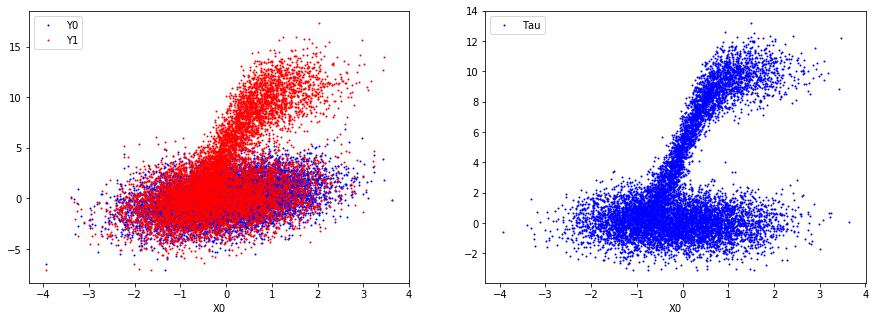

In [198]:
# Your answer here
plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.plot(X[:,0], Y0, 'bo', label = "Y0", markersize=1)
plt.plot(X[:,0], Y1, 'ro', label = "Y1", markersize=1)
plt.xlabel('X0')
plt.legend(loc='upper left')

plt.subplot(122)
plt.plot(X[:,0], Tau, 'bo', label = "Tau", markersize=1)
plt.legend(loc='upper left')
plt.xlabel('X0')

plt.show()

Many of the treatment effects are just the white noise term, which is centered around 0.

>**Ex 4.1.3.** Import `statsmodels` and estimate a simple linear regression
$$
y = \alpha + \delta_0 T + \sum_k \beta_k X_k + \epsilon
$$
>What is your estimate of $\hat{\delta}_0$? How does this number fit with the figures you drew in the previous exercise? Do you have any suggestions for improving the estimate of the model, comment on whether your improvements would provide unbiased estimates of $\tau$? 
>
> **Bonus:** fit your improved model, and relate the parameters you estimate to the figure you plotted in the previous question.

In [210]:
Tau.mean()

2.456337023922106

In [243]:
# Your answer here
import statsmodels.api as sm

# Collect exogenous variables

exog = np.c_[ T, X]  

# Fit and summarize OLS model
mod = sm.OLS(y, exog)

res = mod.fit()

print(res.summary())

print(f"\nThe estimate is 2.46, which is the mean of the treatment effect, and as such I have found the ATE")
print(f"Splitting the sample into bins would give some form of heterogeneous effects")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.481
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     1543.
Date:                Wed, 18 Mar 2020   Prob (F-statistic):               0.00
Time:                        15:22:04   Log-Likelihood:                -24048.
No. Observations:               10000   AIC:                         4.811e+04
Df Residuals:                    9994   BIC:                         4.815e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.4634      0.038     65.393      0.0

>**Ex. 4.1.4:** For this question we will need to move into R (or use rpy2). If you are working in python you can skip this step, otherwise do the following. 
>
> Save a dataframe, containing $X$, $y$, $T$, and $D$ as a csv file on your computer.

In [200]:
# Your answer here

>**Ex. 4.1.5:** Open up R and read the data you just saved into a dataframe(or work in rpy2). Install and load the two libraries `tidyverse` and `grf`.
>
> _Hint:_ to install the required packages. run this:
> ```R
> install.packages("tidyverse")
> install.packages("grf")
> ```

In [201]:
# Your answer here

import rpy2.robjects.packages as rpackages

# import R's utility package
utils = rpackages.importr('utils')

# select a mirror for R packages
utils.chooseCRANmirror(ind=1) # select the first mirror in the list

# R package names
packnames = ('ggplot2', 'hexbin', 'grf', 'tidyverse', 'RCCP')

# R vector of strings
from rpy2.robjects.vectors import StrVector

# Selectively install what needs to be install.
# We are fancy, just because we can.
names_to_install = [x for x in packnames if not rpackages.isinstalled(x)]
if len(names_to_install) > 0:
    utils.install_packages(StrVector(names_to_install))

from rpy2.robjects.packages import importr
grf = importr('grf')
tidyverse = importr('tidyverse')


>**Ex. 4.1.5:** Copy the following code into R to split your dataframe into two matrices, `X`, and `y`. Implement the exact same procedure to create a third matrix `W` which contains the treatment indicator (**Note** `T` is a reserved name in R, so name your third matrix `W`).
>```R
>X <- df %>%
  select(X0, X1, X2, X3, X4, D) %>% 
  as.matrix()
>
>y <- df %>%
  select(y) %>% 
  as.matrix()
>```
> Finally spend some time poking around the [GRF documentation](https://github.com/grf-labs/grf). See if you can figure out how to estimate a GRF model, once you have the three matrices you need (this is way simpler than you might expect).

In [228]:
# Your answer here

import rpy2.robjects as ro
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()

X2 = np.c_[X, D]  

X_r = ro.r.matrix(X2, nrow=10000, ncol=6)
y_r = ro.r.matrix(y, nrow=10000, ncol=1)
T_r = ro.r.matrix(T, nrow=10000, ncol=1)


>**Ex.4.1.6:** Estimate a causal forest model using the GRF package, and store the result in a new variable `cf`. Then use the following line to create a dataframe of predicted treatment effects on the same data that you trained the model on. 
>```R
>cf <- # Estimate a generalized RF model aimed at treatment effects.
>tau <- predict(cf, X)
>```
> Once you have your individual treatment effects, run the following line, to save them in a csv file. 
> ```R
> write.csv(tau, "individual_treatment_effects.csv")
> ```

In [230]:
# Your answer here

from rpy2.robjects import pandas2ri
pandas2ri.activate()

tau_forest = grf.causal_forest(X_r, y_r, T_r)

tau_hat_r = ro.r.predict(tau_forest, X_r)

tau_hat = pandas2ri.ri2py(tau_hat_r)['predictions'].values

>**Ex.4.1.6:** This concludes our venture into R. Now load the treatment effects into a pandas dataframe, and plot a scatterplot of the estimated individual treatment effects against the simulated "true" ITE's `Tau` that you produced in the beginning of this exercise set.

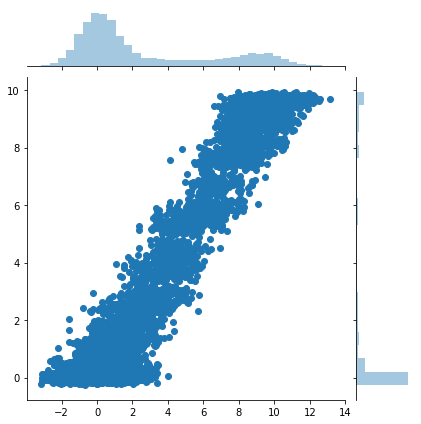

In [235]:
# Your answer here
import seaborn as sns

sns.jointplot(Tau, tau_hat)